In [7]:
from orphics import io, maps, lensing, cosmology, stats
from pixell import enmap, curvedsky
import healpy as hp
import configparser
import numpy as np
import json
from ast import literal_eval
import tools
import matplotlib.pyplot as plt
from symlens import utils

In [10]:
nlev_t = 1
beam_arcmin = 3

ellmin = 30
ellmax = 4000
delta_L = 200

In [2]:
map_source = 'websky'
ksz_type = 'lt'
decmax = 45
width_deg = 10
px_arcmin = 1
cutouts = int(2*decmax/width_deg*(360/width_deg))

In [4]:
# Use maps provided by websky or Colin
map_path = 'maps/' + map_source + '/'
# Path of output data
data_path = 'output/data/'

In [5]:
band_shape, band_wcs = enmap.band_geometry(dec_cut=np.deg2rad(decmax),
                                           res=np.deg2rad(px_arcmin / 60.))

band_modlmap = enmap.modlmap(band_shape, band_wcs)

In [8]:
# Read in cmb_alm
print('reading in CMB map')
cmb_alm = hp.read_alm(map_path + 'lensed_cmb_alm.fits', hdu=1)
# Get cmb band map
cmb_band = curvedsky.alm2map(cmb_alm, enmap.empty(band_shape, band_wcs))

# Read in ksz_alm and get ksz band map
print('reading in %s %s kSZ map' % (map_source, ksz_type))
ksz_alm = hp.read_alm(map_path + f'ksz_{ksz_type}_alm.fits')
ksz_band = curvedsky.alm2map(ksz_alm, enmap.empty(band_shape, band_wcs))

# Read in ksz_g_alm  and get ksz_g_band map, 'g' is for gaussian
print('reading in ksz_g map')
ksz_g_alm = hp.read_alm(map_path + f'ksz_{ksz_type}_g_alm_6000.fits')
ksz_g_band = curvedsky.alm2map(ksz_g_alm, enmap.empty(band_shape, band_wcs))

# Read in input kappa map for cross correlation check
print('reading in kappa map')
kap_alm = hp.read_alm(map_path + 'kappa_alm.fits')
kap_band = curvedsky.alm2map(kap_alm, enmap.empty(band_shape, band_wcs))

npix = int(width_deg * 60 / px_arcmin)
ntiles = int(np.prod(band_shape) / npix**2)
num_x = int(360 / width_deg)

ells = np.arange(0, ellmax, 1)
# lmin, lmax for reconstructed kappa map
Lmin, Lmax = ellmin, ellmax
Cl_noise_TT = (nlev_t * np.pi / 180. / 60.)**2 * np.ones(ells.shape)
# deconvolved noise power spectrum
Cl_noise_TT = Cl_noise_TT / utils.gauss_beam(ells, beam_arcmin)**2
# deconvolved noise band map
noise_band = curvedsky.rand_map(band_shape, band_wcs, Cl_noise_TT)

# cmb_tg
cmb_tg = cmb_band + ksz_g_band + noise_band
st_tg = stats.Stats()
iy, ix = 0, 0

reading in CMB map
reading in websky lt kSZ map
reading in ksz_g map
reading in kappa map
Begin to get <cl_kappa_tg_ave>


In [47]:
# test single cutout reconstruction
cmb_t = cmb_band + ksz_band + noise_band
ex = ix + npix
ey = iy + npix
cut_cmb_t = cmb_t[iy:ey, ix:ex]
cut_wcs = cut_cmb_t.wcs
cut_modlmap =cut_cmb_t.modlmap()
cut_inkap = kap_band[iy:ey, ix:ex]
results_t = tools.Rec(ellmin,
                          ellmax,
                          Lmin,
                          Lmax,
                          delta_L,
                          nlev_t,
                          beam_arcmin,
                          enmap1=cut_cmb_t,
                          enmap2=cut_cmb_t)

In [48]:
def powspec(enmap1, enmap2=None, taper_order=2, lmin=None, lmax=None, delta_l=None, weights= None):

    shape = enmap1.shape
    wcs = enmap1.wcs
    modlmap = enmap.modlmap(shape, wcs)

    bin_edges = np.arange(lmin, lmax, delta_l)
    binner = utils.bin2D(modlmap, bin_edges)
    taper, w2 = maps.get_taper_deg(shape, wcs)
    # w is for correction of powerspectrum
    w = np.mean(taper**taper_order)

    enmap1 = taper*enmap1
    enmap1_k = enmap.fft(enmap1, normalize='phys')

    if enmap2 is not None:
        enmap2 = taper*enmap2
        enmap2_k = enmap.fft(enmap2, normalize='phys')
        p2d = (enmap1_k * enmap2_k.conj()).real / w
    else:
        enmap2_k = None
        p2d = (enmap1_k * enmap1_k.conj()).real / w

    centers, p1d = binner.bin(p2d, weights=weights)
    return centers, p1d

In [49]:
Ls = results_t['Ls']
cut_reckap = results_t['reckap']
cut_reckap_cl = results_t['reckap_x_reckap']
weights = (2*cut_modlmap +1)
cut_inkap_cl = powspec(cut_inkap, lmin=Lmin, lmax=Lmax, delta_l=delta_L)[1]
cut_inkap_cl_w = powspec(cut_inkap, lmin=Lmin, lmax=Lmax, delta_l=delta_L, weights=weights)[1]

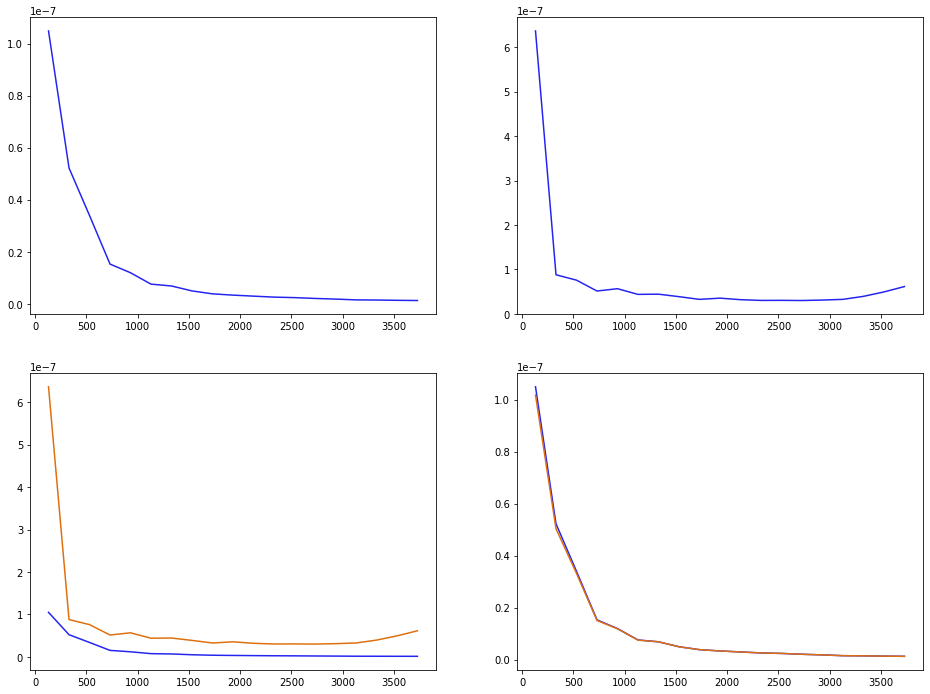

In [52]:
column, row = 2, 2
fig, ax = plt.subplots(column,row,figsize=(8*column,6*row))
ax[0,0].plot(Ls, cut_inkap_cl)
ax[0,1].plot(Ls, cut_reckap_cl)
ax[1,0].plot(Ls, cut_inkap_cl)
ax[1,0].plot(Ls, cut_reckap_cl)
ax[1,1].plot(Ls, cut_inkap_cl)
ax[1,1].plot(Ls, cut_inkap_cl_w)
#plt.loglog()

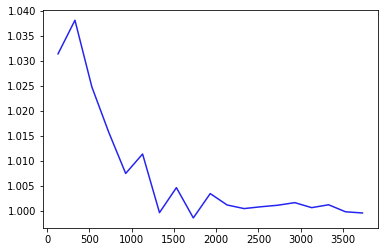

In [54]:
plt.plot(Ls, cut_inkap_cl/cut_inkap_cl_w)

/global/u2/h/hongbo/tools/pixell/pixell/enplot.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  crange[0,np.isnan(crange[0])] = v1
/global/u2/h/hongbo/tools/pixell/pixell/enplot.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  crange[1,np.isnan(crange[1])] = v2
/global/u2/h/hongbo/tools/pixell/pixell/colorize.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  _colorize.remap(a, res.T, desc.vals, desc.cols.astype(np.int16).T)


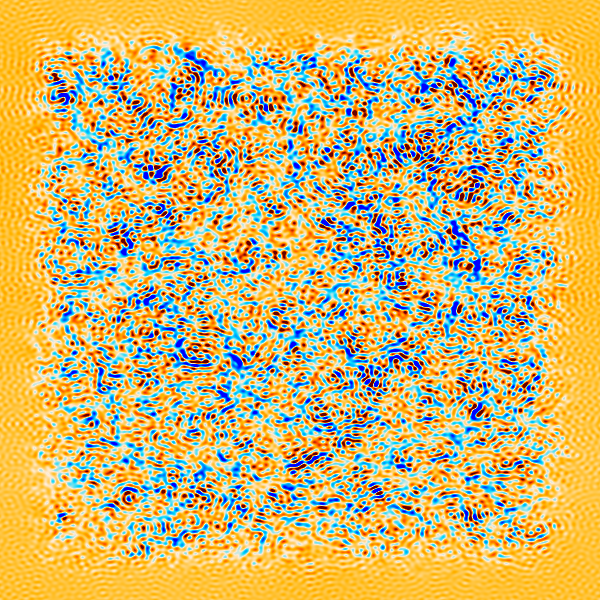

In [22]:
io.hplot(cut_reckap)